In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import tikzplotlib
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import kmapper as km

from kmapper import jupyter
from itertools import cycle
from sklearn import metrics
from collections import OrderedDict
from sklearn.cluster import KMeans, AgglomerativeClustering, OPTICS
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split, GridSearchCV
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

sns.set_style('darkgrid')

## Load extracted features

In [2]:
df = pd.read_json('./data/features.json', lines=True)
embedding_dim = np.shape(df.features.values[0])[0]
# Expand features into columns
df_features = pd.DataFrame([feat for feat in df.features.values])
df = df_features.assign(method_name=df.method_name)
df
df

,0,1,2,3,4,5,6,7,8,9,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,method_name
0,0.064520,1.199874,0.582989,0.417247,-0.810534,0.096447,0.567091,-0.724707,-0.663345,1.720038,...,-0.272473,0.188706,0.506290,1.537280,0.286274,0.164183,0.341690,-0.060961,1.586969,test_no_save_returns_none
1,0.541495,1.339559,0.691412,0.555565,-1.037268,0.030020,0.455849,-0.628792,-0.670024,1.770876,...,-0.203936,0.012250,0.517400,1.728109,0.253695,0.041702,0.210884,0.179591,1.313099,test_save_returns_name
2,0.092729,0.702569,0.659374,0.214629,-0.766561,-0.212676,0.655865,-0.936573,-0.798832,1.812880,...,-0.058906,-0.311678,0.848650,1.437981,0.190635,-0.116690,0.227977,0.175588,1.358044,test_away_saves_single_goalies
3,-0.071796,0.042721,0.321901,-0.019990,-0.483819,0.036867,0.869146,-0.579781,-0.698545,1.737027,...,0.057563,0.060343,0.748921,1.303969,-0.005239,-0.106094,0.343743,-0.309685,1.267721,test_away_saves_multiple_goalies_empty_field
4,0.129667,0.437085,0.335082,0.126753,-0.730406,-0.084024,0.702218,-0.764644,-0.862530,1.729893,...,0.152357,-0.108680,0.783611,1.463867,0.224406,-0.057166,0.222614,-0.253140,1.292048,test_away_saves_multiple_goalies_empty_field
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38313,-0.569630,0.319090,0.357420,0.095631,-0.335438,0.027710,1.224471,-0.453569,-0.515486,1.726791,...,-0.431455,0.459465,0.161778,1.932298,-0.110179,0.098422,-0.309218,0.295730,1.234345,predict_fn_multi
38314,-0.923918,0.375725,0.695250,0.481736,-0.772844,0.117793,0.541488,-0.904890,-0.091457,1.980443,...,-0.502705,0.477413,0.896385,1.179612,-0.326916,0.763361,-0.113822,0.548153,0.858148,predict
38315,0.122254,0.292974,0.174842,0.621810,-1.580733,-0.112164,0.627229,0.174072,-0.871299,1.675669,...,0.218280,0.180602,0.473770,1.832191,-0.160660,-0.378779,-0.149108,-0.219085,2.211687,_run_forward
38316,-0.460350,0.507438,0.858284,0.653300,-0.979086,0.402865,0.727125,-0.508999,-0.725897,2.062790,...,0.229136,0.201765,0.600646,2.105802,-0.065710,-0.306760,-0.518023,-0.142370,1.477267,_preprocess_img


In [3]:
classes = { 0: 'train', 1: 'save', 2: 'process', 3: 'forward', 4: 'predict' }

In [4]:
# Assign categories based on method name
df['category'] = df.method_name.map(lambda x: np.array([x.find(s) for s in classes.values()]).argmax())
df

,0,1,2,3,4,5,6,7,8,9,...,1016,1017,1018,1019,1020,1021,1022,1023,method_name,category
0,0.064520,1.199874,0.582989,0.417247,-0.810534,0.096447,0.567091,-0.724707,-0.663345,1.720038,...,0.188706,0.506290,1.537280,0.286274,0.164183,0.341690,-0.060961,1.586969,test_no_save_returns_none,1
1,0.541495,1.339559,0.691412,0.555565,-1.037268,0.030020,0.455849,-0.628792,-0.670024,1.770876,...,0.012250,0.517400,1.728109,0.253695,0.041702,0.210884,0.179591,1.313099,test_save_returns_name,1
2,0.092729,0.702569,0.659374,0.214629,-0.766561,-0.212676,0.655865,-0.936573,-0.798832,1.812880,...,-0.311678,0.848650,1.437981,0.190635,-0.116690,0.227977,0.175588,1.358044,test_away_saves_single_goalies,1
3,-0.071796,0.042721,0.321901,-0.019990,-0.483819,0.036867,0.869146,-0.579781,-0.698545,1.737027,...,0.060343,0.748921,1.303969,-0.005239,-0.106094,0.343743,-0.309685,1.267721,test_away_saves_multiple_goalies_empty_field,1
4,0.129667,0.437085,0.335082,0.126753,-0.730406,-0.084024,0.702218,-0.764644,-0.862530,1.729893,...,-0.108680,0.783611,1.463867,0.224406,-0.057166,0.222614,-0.253140,1.292048,test_away_saves_multiple_goalies_empty_field,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38313,-0.569630,0.319090,0.357420,0.095631,-0.335438,0.027710,1.224471,-0.453569,-0.515486,1.726791,...,0.459465,0.161778,1.932298,-0.110179,0.098422,-0.309218,0.295730,1.234345,predict_fn_multi,4
38314,-0.923918,0.375725,0.695250,0.481736,-0.772844,0.117793,0.541488,-0.904890,-0.091457,1.980443,...,0.477413,0.896385,1.179612,-0.326916,0.763361,-0.113822,0.548153,0.858148,predict,4
38315,0.122254,0.292974,0.174842,0.621810,-1.580733,-0.112164,0.627229,0.174072,-0.871299,1.675669,...,0.180602,0.473770,1.832191,-0.160660,-0.378779,-0.149108,-0.219085,2.211687,_run_forward,3
38316,-0.460350,0.507438,0.858284,0.653300,-0.979086,0.402865,0.727125,-0.508999,-0.725897,2.062790,...,0.201765,0.600646,2.105802,-0.065710,-0.306760,-0.518023,-0.142370,1.477267,_preprocess_img,2


In [5]:
df.groupby('category').size()

category
0     9331
1     4559
2     4845
3    12429
4     7154
dtype: int64

In [6]:
train_df, val_df = train_test_split(df, test_size=0.2)
print(f"{len(train_df)} training samples, {len(val_df)} validation samples")

30654 training samples, 7664 validation samples


In [7]:
train_features = train_df.iloc[:, 0:embedding_dim].values
val_features = val_df.iloc[:, 0:embedding_dim].values

## Reduce Dimensionality with an Autoencoder

In [8]:
class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim   
        self.encoder = tf.keras.Sequential([
          layers.Flatten(),
          layers.Dense(latent_dim, activation='relu'),
        ])
        self.decoder = tf.keras.Sequential([
          layers.Dense(embedding_dim, activation='sigmoid')
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [9]:
## Train autoencoder

latent_dim = 10
autoencoder = Autoencoder(latent_dim)
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())
autoencoder.fit(train_features, train_features,
                epochs=20,
                shuffle=True,
                validation_data=(val_features, val_features),
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3)])

Epoch 1/20
958/958 [==============================] - 2s 1ms/step - loss: 0.6040 - val_loss: 0.5280
Epoch 2/20
958/958 [==============================] - 1s 934us/step - loss: 0.5276 - val_loss: 0.5237
Epoch 3/20
958/958 [==============================] - 1s 929us/step - loss: 0.5234 - val_loss: 0.5215
Epoch 4/20
958/958 [==============================] - 1s 927us/step - loss: 0.5216 - val_loss: 0.5208
Epoch 5/20
958/958 [==============================] - 1s 927us/step - loss: 0.5209 - val_loss: 0.5206
Epoch 6/20
958/958 [==============================] - 1s 929us/step - loss: 0.5207 - val_loss: 0.5204
Epoch 7/20
958/958 [==============================] - 1s 947us/step - loss: 0.5205 - val_loss: 0.5202
Epoch 8/20
958/958 [==============================] - 1s 941us/step - loss: 0.5203 - val_loss: 0.5197
Epoch 9/20
958/958 [==============================] - 1s 927us/step - loss: 0.5200 - val_loss: 0.5196


In [10]:

# Consider a subset of samples, taking an equal number of instances from each category
df_subset = df.groupby('category').apply(lambda grp: grp.sample(n=100)).reset_index(level=[0, 1], drop=True)
df_subset.groupby('category').size()

category
0    100
1    100
2    100
3    100
4    100
dtype: int64

In [11]:
# Choose the "default" high dim features
features = df_subset.iloc[:, 0:embedding_dim].values

# Map the features into a low dimensional space using the encoder
# features = autoencoder.encoder(df_subset.iloc[:, 0:embedding_dim].values).numpy()
features.shape

(500, 1024)

In [12]:
def plot_clusters(estimator, dataframe, labels):
    # Get features from dataframe
    features = dataframe.iloc[:, 0:embedding_dim].values
    
    k = len(np.unique(labels))
    # Print metrics
    print('Number of clusters: %d' % k)
    print("Homogeneity: %0.3f" % metrics.homogeneity_score(dataframe['category'], labels))
    print("Completeness: %0.3f" % metrics.completeness_score(dataframe['category'], labels))
    print("V-measure: %0.3f" % metrics.v_measure_score(dataframe['category'], labels))
    print("Adjusted Rand Index: %0.3f"
          % metrics.adjusted_rand_score(dataframe['category'], labels))
    print("Adjusted Mutual Information: %0.3f"
          % metrics.adjusted_mutual_info_score(dataframe['category'], labels))
    print("Jaccard Coefficients: %s"
          % metrics.jaccard_score(dataframe['category'], labels, average=None))
    print("Silhouette Coefficient: %0.3f"
          % metrics.silhouette_score(features, labels, metric='sqeuclidean'))

    # Visualize clusters with tSNE
    fig = plt.figure(figsize=(14,5))
    fig.suptitle('Visualizing clusters with tSNE')
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.set_title(f'{estimator.__class__.__name__} Clusters (k={k})')
    colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
    ax1.scatter(tsne_result[:, 0], tsne_result[:, 1], tsne_result[:, 2], c='k', marker='+', alpha=0.1)
    for klass, color in zip(range(0, k), colors):
        Xk = tsne_result[labels == klass]
        ax1.scatter(Xk[:, 0], Xk[:, 1], Xk[:, 2], c=color, alpha=0.3)

    ax2 = fig.add_subplot(122, projection='3d')
    ax2.set_title('True labels')
    colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
    for klass, color in zip(range(0, len(classes)), colors):
        Xk = tsne_result[dataframe['category'] == klass]
        ax2.scatter(Xk[:, 0], Xk[:, 1],  Xk[:, 2], c=color, alpha=0.3, label=classes[klass])
    ax2.legend()
    
    tikzplotlib.save(f"./figures/cubert_features_{estimator.__class__.__name__}.tex")
    
    
def cv_silhouette_scorer(estimator, X):
    estimator.fit(X)
    if (estimator.__class__.__name__ == "OPTICS"):
        cluster_labels = estimator.labels_[estimator.ordering_]
    else:
        cluster_labels = estimator.labels_
    num_labels = len(set(cluster_labels))
    num_samples = len(X)
    if num_labels == 1 or num_labels == num_samples:
        return -1
    else:
        return metrics.silhouette_score(X, cluster_labels, metric='sqeuclidean')

def get_estimator_name(estimator):
    return estimator.__class__.__name__

In [13]:
# Compute tSNE to visualize clusters
tsne = TSNE(n_components=3, verbose=1, perplexity=30, n_iter=3000)
tsne_result = tsne.fit_transform(features)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 500 samples in 0.000s...
[t-SNE] Computed neighbors for 500 samples in 0.013s...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 4.054139
[t-SNE] KL divergence after 250 iterations with early exaggeration: 113.457375
[t-SNE] KL divergence after 3000 iterations: 1.449882


In [14]:
estimators = OrderedDict()

## Centroid-based clustering using K-means

Best silhouette score 0.260 achieved with 3 clusters
Number of clusters: 3
Homogeneity: 0.028
Completeness: 0.041
V-measure: 0.033
Adjusted Rand Index: 0.023
Adjusted Mutual Information: 0.027
Jaccard Coefficients: [0.18565401 0.16386555 0.17475728 0.         0.        ]
Silhouette Coefficient: 0.260


<IPython.core.display.Javascript object>


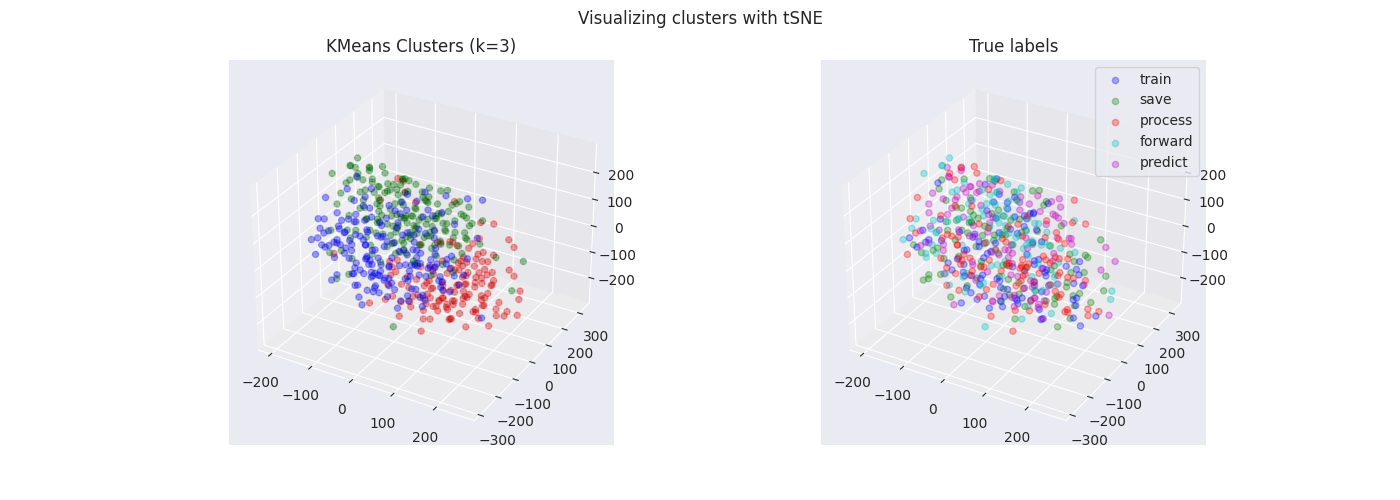

In [15]:
# Apply K-means
search_params = {'n_clusters': np.arange(2,11)}

cv = [(slice(None), slice(None))] # Disable cv, only want grid search
gs = GridSearchCV(estimator=KMeans(random_state=0), param_grid=search_params, 
                  scoring=cv_silhouette_scorer, cv=cv, n_jobs=-1)

res = gs.fit(X=features, y=None)

max_silhouette_score = np.max(res.cv_results_['mean_test_score'])
ind = np.argmax(res.cv_results_['mean_test_score'])
k = search_params['n_clusters'][ind]

print(f"Best silhouette score {max_silhouette_score:.3f} achieved with {k} clusters")
kmeans_estimator = KMeans(n_clusters=k, random_state=0)
estimators[get_estimator_name(kmeans_estimator)] = { 'estimator': kmeans_estimator, 'score':  max_silhouette_score }

kmeans = kmeans_estimator.fit(features)
plot_clusters(kmeans, df_subset, kmeans.labels_)

## Density-Based Clustering using OPTICS

Best silhouette score 0.132 achieved with {'cluster_method': 'xi', 'metric': 'cosine', 'min_samples': 5, 'xi': 0.1}
Number of clusters: 5
Homogeneity: 0.049
Completeness: 0.271
V-measure: 0.083
Adjusted Rand Index: 0.002
Adjusted Mutual Information: 0.064
Jaccard Coefficients: [0.   0.08 0.   0.   0.   0.  ]
Silhouette Coefficient: -0.225


<IPython.core.display.Javascript object>


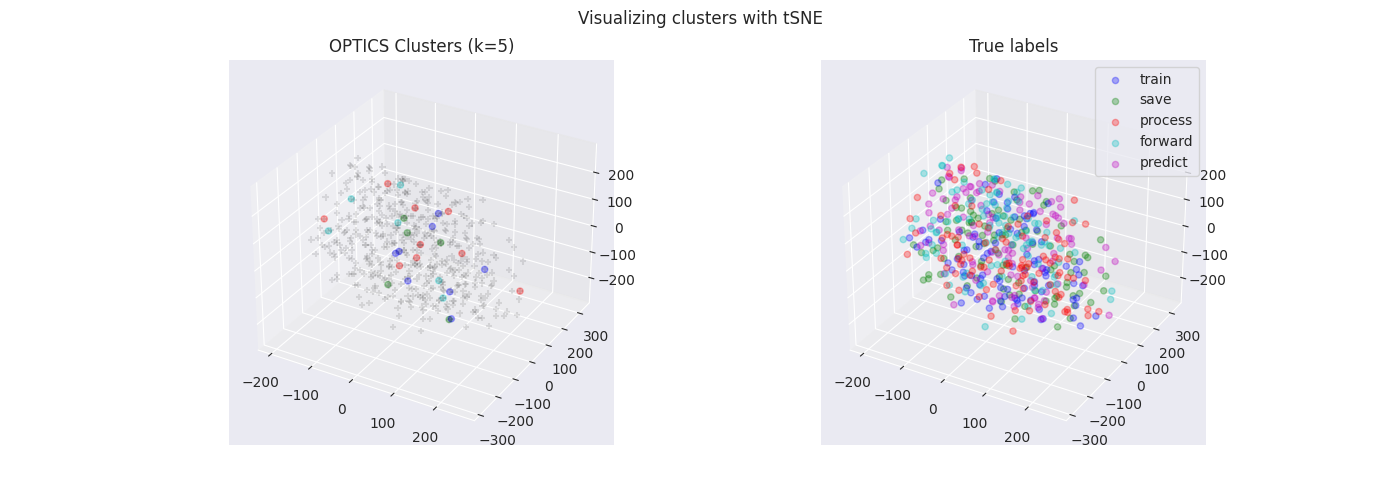

In [16]:
search_params = {'cluster_method': ['xi', 'dbscan'], 'xi': np.linspace(0,1,11), 'min_samples': [2,5,10,15,20,25,30], 'metric': ['minkowski', 'cosine', 'euclidean', 'sqeuclidean']}

cv = [(slice(None), slice(None))] # Disable cv, only want grid search
gs = GridSearchCV(estimator=OPTICS(cluster_method='xi'), param_grid=search_params, 
                  scoring=cv_silhouette_scorer, cv=cv, n_jobs=-1)

res = gs.fit(X=features, y=None)

# Get best configuration
max_silhouette_score = np.max(res.cv_results_['mean_test_score'])
ind = np.argmax(res.cv_results_['mean_test_score'])
best_params = res.cv_results_['params'][ind]
k = best_params['min_samples']
metric = best_params['metric']

# Visualize best clusters
print(f"Best silhouette score {max_silhouette_score:.3f} achieved with {res.cv_results_['params'][ind]}")
optics_estimator = OPTICS(cluster_method='xi', min_samples=k, metric=metric)
estimators[get_estimator_name(optics_estimator)] = { 'estimator': optics_estimator, 'score':  max_silhouette_score }

optics_clusters = optics_estimator.fit(features)
plot_clusters(optics_clusters, df_subset, optics_clusters.labels_[optics_clusters.ordering_])

## Agglomerative Clustering (Hierarchical)

Best silhouette score 0.448 achieved with {'linkage': 'average', 'n_clusters': 2}
Number of clusters: 2
Homogeneity: 0.003
Completeness: 0.100
V-measure: 0.007
Adjusted Rand Index: 0.000
Adjusted Mutual Information: 0.001
Jaccard Coefficients: [0.2020202 0.        0.        0.        0.       ]
Silhouette Coefficient: 0.448


<IPython.core.display.Javascript object>


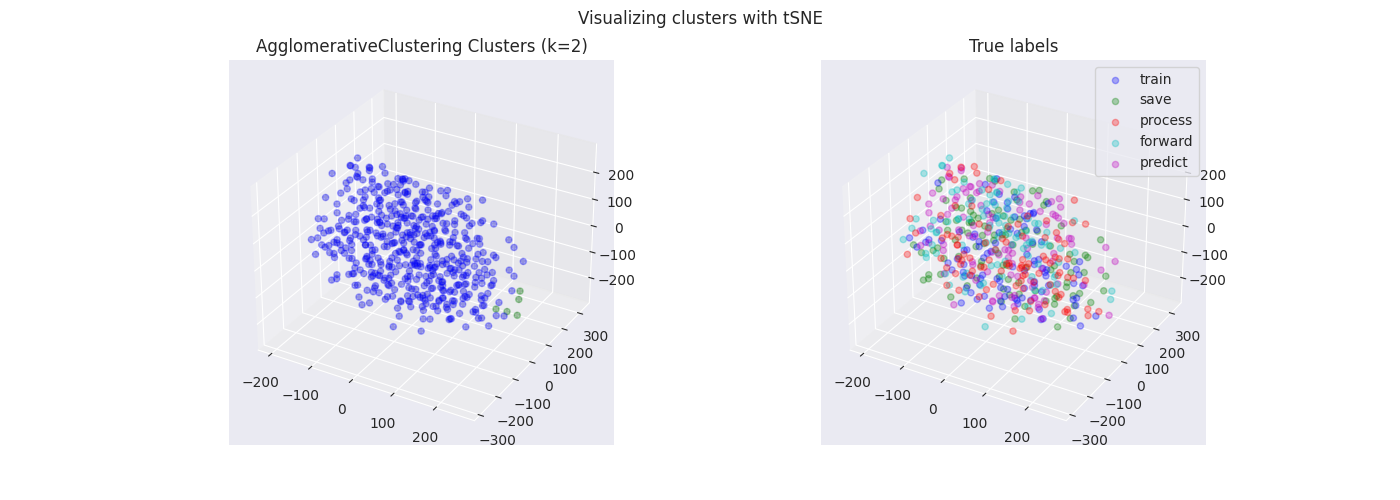

In [17]:
search_params = {'n_clusters':  np.arange(2,11), 'linkage': ['ward', 'complete', 'average', 'single']}
# search_params = {'n_clusters': np.arange(2,11), 'linkage': ['complete', 'average', 'single'], 'affinity': ['euclidean', 'l1', 'l2', 'manhattan', 'cosine']}

cv = [(slice(None), slice(None))] # Disable cv, only want grid search
gs = GridSearchCV(estimator=AgglomerativeClustering(linkage='ward'), param_grid=search_params, 
                  scoring=cv_silhouette_scorer, cv=cv, n_jobs=-1)

res = gs.fit(X=features, y=None)

# Get best configuration
max_silhouette_score = np.max(res.cv_results_['mean_test_score'])
ind = np.argmax(res.cv_results_['mean_test_score'])
best_params = res.cv_results_['params'][ind]
k = best_params['n_clusters']
linkage = best_params['linkage']

# Visualize best clusters
print(f"Best silhouette score {max_silhouette_score:.3f} achieved with {res.cv_results_['params'][ind]}")
agglomerative_estimator = AgglomerativeClustering(n_clusters=k, linkage=linkage)
estimators[get_estimator_name(agglomerative_estimator)] = { 'estimator': agglomerative_estimator, 'score':  max_silhouette_score}
agglomerative_clusters = agglomerative_estimator.fit(features)
plot_clusters(agglomerative_clusters, df_subset, agglomerative_clusters.labels_)

## Select best estimator

In [18]:
scores = [val['score'] for val in estimators.values()]
ind = np.argmax(scores)
best_estimator = list(estimators.values())[ind]['estimator']

In [19]:
print(f"Best cluster method: {get_estimator_name(best_estimator)}\nParams:\n{best_estimator.__dict__}")

Best cluster method: AgglomerativeClustering
Params:
{'n_clusters': 2, 'distance_threshold': None, 'memory': None, 'connectivity': None, 'compute_full_tree': 'auto', 'linkage': 'average', 'affinity': 'euclidean', 'compute_distances': False, 'n_features_in_': 1024, 'children_': array([[327, 341],
       [410, 431],
       [ 32, 464],
       [ 85, 502],
       [424, 462],
       [469, 503],
       [233, 505],
       [253, 288],
       [238, 293],
       [ 47,  76],
       [ 20, 494],
       [ 60, 283],
       [387, 500],
       [294, 511],
       [430, 506],
       [ 95, 267],
       [429, 468],
       [  2, 277],
       [ 45, 514],
       [324, 359],
       [369, 504],
       [482, 510],
       [231, 517],
       [ 30, 120],
       [ 58, 142],
       [509, 518],
       [175, 422],
       [360, 450],
       [513, 515],
       [ 73, 522],
       [176, 211],
       [243, 281],
       [ 88, 528],
       [153, 458],
       [337, 527],
       [336, 520],
       [251, 532],
       [131, 444],


## Visualize Clusters with Kepler Mapper

In [20]:
# Visualize with kepler map
mapper = km.KeplerMapper(verbose=1)

# Fit and transform data, use TSNE 
projected_data = mapper.fit_transform(features, projection=TSNE(n_components=2))

# Create the graph (we cluster on the projected data and suffer projection loss)
graph = mapper.map(
    projected_data,
    clusterer=best_estimator,
#     clusterer=agglomerative_estimator,
    cover=km.Cover(5, 0.3),
)

# Create the visualizations
print("Output graph examples to html")
mapper.visualize(
    graph,
    title=f"Cubert Feature Mapper",
    path_html=f"./data/cubert_features_visualization.html",
    custom_tooltips=df['category'].values
)

jupyter.display(path_html=f"./data/cubert_features_visualization.html")

KeplerMapper(verbose=1)
..Composing projection pipeline of length 1:
	Projections: TSNE()
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (500, 1024)

..Projecting data using: 
	TSNE(verbose=1)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 500 samples in 0.000s...
[t-SNE] Computed neighbors for 500 samples in 0.014s...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 4.054139
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.799538
[t-SNE] KL divergence after 1000 iterations: 0.847152

..Scaling with: MinMaxScaler()

Mapping on data shaped (500, 2) using lens shaped (500, 2)

Creating 25 hypercubes.

Created 105 edges and 50 nodes in 0:00:00.010985.
Output graph examples to html
Wrote visualization to: ./data/cubert_features_visualization.html


/home/marcus/.local/lib/python3.8/site-packages/IPython/core/display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")
